In [21]:
import pm4py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

output_dir = Path("../../Results/Advanced_Analysis/activity_lifecycle_kmeans")
output_dir.mkdir(parents=True, exist_ok=True)

print("Libraries ready")


Libraries ready


In [22]:
log_path = "../../Dataset/BPI Challenge 2017.xes"
log = pm4py.read_xes(log_path)
df = pm4py.convert_to_dataframe(log)

# Ensure ordering
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'], utc=True)
df = df.sort_values(['case:concept:name', 'time:timestamp']).reset_index(drop=True)

print(f"Events: {len(df):,}")
print(f"Cases: {df['case:concept:name'].nunique():,}")
print(f"Activities: {df['concept:name'].nunique()}, lifecycle tags: {df['lifecycle:transition'].nunique()}")


Events: 1,202,267
Cases: 31,509
Activities: 26, lifecycle tags: 7


In [23]:
def classify_outcome(seq):
    if seq is None or len(seq) == 0:
        return 'Unknown'
    acts = set(seq)
    if 'A_Denied' in acts:
        return 'Denied'
    if 'A_Cancelled' in acts:
        return 'Cancelled'
    if 'A_Pending' in acts:
        return 'Pending'
    return 'Other'


In [24]:
case_data = df.groupby('case:concept:name').agg({
    'time:timestamp': ['min', 'max'],
    'concept:name': list
}).reset_index()

case_data.columns = ['case_id', 'start_time', 'end_time', 'activity_sequence']
case_data['duration_days'] = (case_data['end_time'] - case_data['start_time']).dt.total_seconds() / (24 * 3600)
case_data['num_events'] = case_data['activity_sequence'].apply(len)
case_data['outcome'] = case_data['activity_sequence'].apply(classify_outcome)

summary = {
    'cases': len(case_data),
    'median_duration_days': case_data['duration_days'].median(),
    'median_events': case_data['num_events'].median()
}

print(summary)
print("Outcome counts:\n", case_data['outcome'].value_counts())



{'cases': 31509, 'median_duration_days': np.float64(19.087739212962962), 'median_events': np.float64(35.0)}
Outcome counts:
 outcome
Pending      17228
Cancelled    10431
Denied        3752
Other           98
Name: count, dtype: int64


In [25]:
df['lifecycle:transition'] = df['lifecycle:transition'].fillna('unknown')
df['act_lifecycle'] = df['concept:name'] + '/' + df['lifecycle:transition']

combo_counts = df['act_lifecycle'].value_counts()
selected_combos = combo_counts.head(5).index.tolist()
print(f"Using top {len(selected_combos)} activity-lifecycle pairs out of {combo_counts.shape[0]}")

case_combo = (df[df['act_lifecycle'].isin(selected_combos)]
              .groupby(['case:concept:name', 'act_lifecycle'])
              .size()
              .unstack(fill_value=0))

case_combo = case_combo.reindex(columns=selected_combos, fill_value=0)
case_combo = case_combo.div(case_combo.sum(axis=1).replace(0, 1), axis=0)  # normalized frequencies

feature_df = case_combo.merge(case_data[['case_id']],
                               left_index=True, right_on='case_id')
feature_df = feature_df.set_index('case_id')

print(feature_df.head())



Using top 5 activity-lifecycle pairs out of 66
                        W_Call after offers/suspend  \
case_id                                               
Application_1000086665                     0.500000   
Application_1000158214                     0.250000   
Application_1000311556                     0.500000   
Application_1000334415                     0.285714   
Application_1000339879                     0.222222   

                        W_Call incomplete files/suspend  \
case_id                                                   
Application_1000086665                         0.000000   
Application_1000158214                         0.000000   
Application_1000311556                         0.000000   
Application_1000334415                         0.285714   
Application_1000339879                         0.111111   

                        W_Validate application/suspend  O_Created/complete  \
case_id                                                                    

k=2: silhouette=0.488, inertia=71520
k=3: silhouette=0.410, inertia=55298
k=4: silhouette=0.429, inertia=41492
k=5: silhouette=0.470, inertia=31887
k=6: silhouette=0.475, inertia=26494
k=7: silhouette=0.484, inertia=23372
k=8: silhouette=0.493, inertia=20927
k=9: silhouette=0.500, inertia=18445

Optimal k=9 (silhouette=0.500)


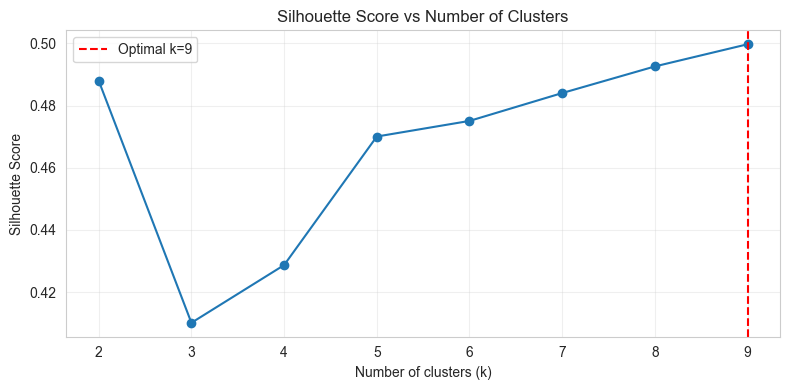


Final clustering with k=9:
cluster
0    2747
1    4087
2    6413
3    5802
4    1873
5     643
6    3290
7    3801
8    2853
Name: count, dtype: int64
Silhouette score: 0.500


In [26]:
# Test multiple k values to find optimal number of clusters
X = feature_df[selected_combos]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_range = range(2, 10)
silhouette_scores = []
inertias = []

for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels_test = kmeans_test.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels_test)
    silhouette_scores.append(sil)
    inertias.append(kmeans_test.inertia_)
    print(f"k={k}: silhouette={sil:.3f}, inertia={kmeans_test.inertia_:.0f}")

# Find optimal k (highest silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal k={optimal_k} (silhouette={max(silhouette_scores):.3f})")

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, marker='o')
plt.axvline(optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(output_dir / 'silhouette_scores.png', dpi=150)
plt.show()

# Perform final clustering with optimal k
k = optimal_k
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
cluster_labels = kmeans.fit_predict(X_scaled)

feature_df['cluster'] = cluster_labels
case_data = case_data.merge(feature_df[['cluster']], left_on='case_id', right_index=True)

print(f"\nFinal clustering with k={k}:")
print(feature_df['cluster'].value_counts().sort_index())
print(f"Silhouette score: {silhouette_score(X_scaled, cluster_labels):.3f}")


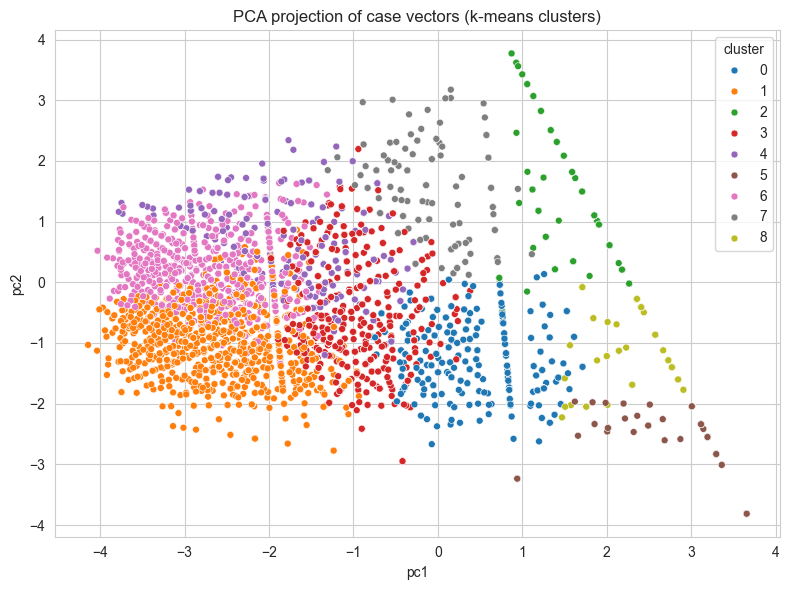

In [27]:
pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(X_scaled)

plot_df = pd.DataFrame({
    'pc1': pca_coords[:, 0],
    'pc2': pca_coords[:, 1],
    'cluster': cluster_labels,
    'duration_days': case_data.set_index('case_id').loc[feature_df.index]['duration_days']
})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x='pc1', y='pc2', hue='cluster', palette='tab10', s=25)
plt.title('PCA projection of case vectors (k-means clusters)')
plt.tight_layout()
plt.savefig(output_dir / 'pca_clusters.png', dpi=150)
plt.show()



outcome  Cancelled    Denied     Other   Pending
cluster                                         
0         0.026210  0.231889  0.001456  0.740444
1         0.120137  0.087350  0.008319  0.784194
2         0.980352  0.010759  0.000000  0.008888
3         0.048087  0.091520  0.000862  0.859531
4         0.011746  0.289909  0.000000  0.698345
5         0.769829  0.143079  0.038880  0.048212
6         0.034347  0.094225  0.000000  0.871429
7         0.005788  0.292292  0.000000  0.701921
8         0.928847  0.035752  0.010515  0.024886


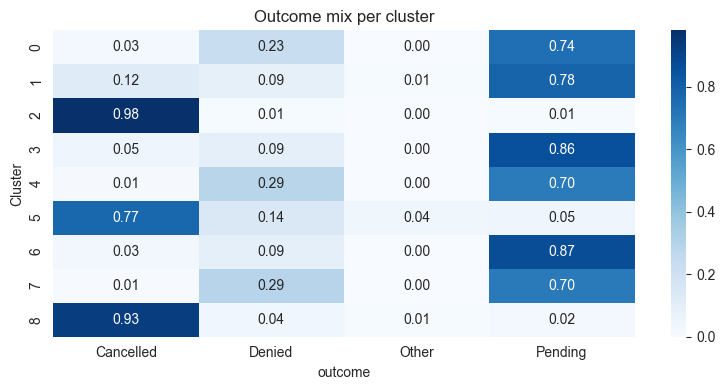

In [28]:
if 'outcome' not in case_data.columns:
    case_data['outcome'] = case_data['activity_sequence'].apply(classify_outcome)

cluster_outcome = pd.crosstab(case_data['cluster'], case_data['outcome'], normalize='index')
print(cluster_outcome)

plt.figure(figsize=(8, 4))
sns.heatmap(cluster_outcome, annot=True, fmt='.2f', cmap='Blues')
plt.title('Outcome mix per cluster')
plt.ylabel('Cluster')
plt.tight_layout()
plt.savefig(output_dir / 'cluster_outcome_heatmap.png', dpi=150)
plt.show()



Cluster sizes:
 cluster
0    2747
1    4087
2    6413
3    5802
4    1873
5     643
6    3290
7    3801
8    2853
Name: count, dtype: int64


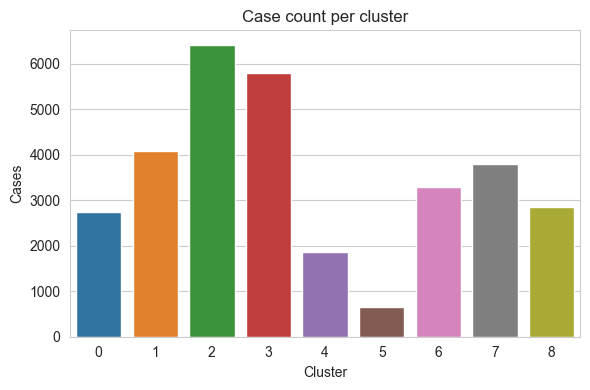

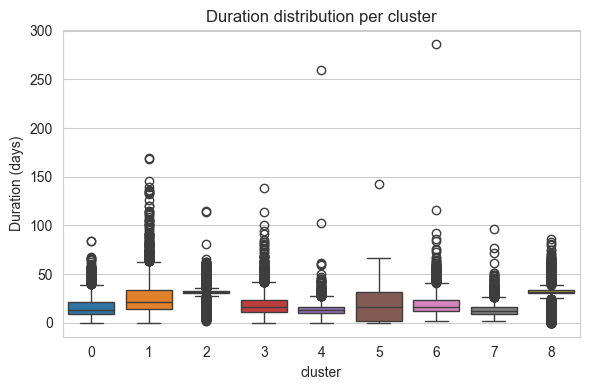

In [29]:
cluster_sizes = feature_df['cluster'].value_counts().sort_index()
print("Cluster sizes:\n", cluster_sizes)

plt.figure(figsize=(6, 4))
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='tab10')
plt.xlabel('Cluster')
plt.ylabel('Cases')
plt.title('Case count per cluster')
plt.tight_layout()
plt.savefig(output_dir / 'cluster_sizes.png', dpi=150)
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=case_data, x='cluster', y='duration_days', palette='tab10')
plt.ylabel('Duration (days)')
plt.title('Duration distribution per cluster')
plt.tight_layout()
plt.savefig(output_dir / 'cluster_duration_boxplot.png', dpi=150)
plt.show()



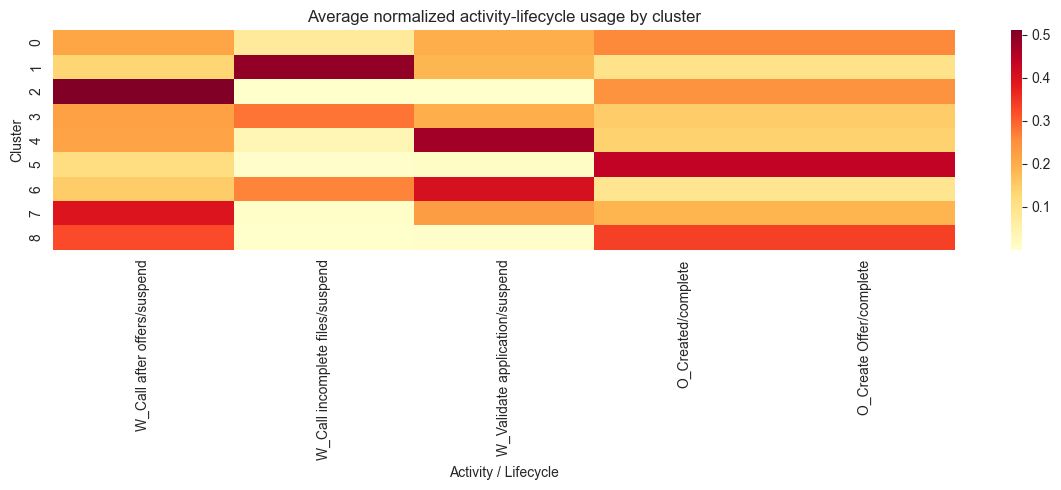

In [30]:
cluster_combo_mean = feature_df.groupby('cluster')[selected_combos].mean()

plt.figure(figsize=(12, 5))
sns.heatmap(cluster_combo_mean, cmap='YlOrRd', annot=False)
plt.title('Average normalized activity-lifecycle usage by cluster')
plt.xlabel('Activity / Lifecycle')
plt.ylabel('Cluster')
plt.tight_layout()
plt.savefig(output_dir / 'cluster_combo_heatmap.png', dpi=150)
plt.show()

